In [1]:
!pip install torch torchvision --quiet
!pip install roboflow --quiet
!pip install wandb --quiet
!pip install pycocotools --quiet

In [2]:
import os
from google.colab import userdata
import wandb
from roboflow import Roboflow

In [3]:
try:
    rf_key = userdata.get('Roboflow')
    wandb_key = userdata.get('WanDB')
except userdata.SecretNotFoundError:
    print("Error: Pastikan 'secret' Anda di Colab dinamai 'Roboflow' dan 'WanDB'")
except userdata.NotebookAccessError:
    print("Error: Pastikan Anda sudah menyalakan 'Akses notebook' (toggle biru) untuk secret Anda.")
    raise

In [4]:
wandb.login(key=wandb_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aliframadhan2410 (aliframadhan2410-institute-of-ten-nopember) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
rf = Roboflow(api_key=rf_key)

In [6]:
project = rf.workspace("computer-vision-exercise").project("panoptic-indoor-segmentation-7d7wi")

loading Roboflow workspace...
loading Roboflow project...


In [7]:
dataset = project.version(1).download("coco")

In [8]:
!pip install pycocotools --quiet
!pip install opencv-python-headless --quiet

In [9]:
import os
import json
import torch
import torchvision
import numpy as np
import cv2
import random
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from google.colab.patches import cv2_imshow

import wandb

In [10]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

--2025-11-13 18:04:21--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.1’

engine.py.1         100%[===================>]   3.97K  --.-KB/s    in 0s      

2025-11-13 18:04:21 (50.6 MB/s) - ‘engine.py.1’ saved [4063/4063]

--2025-11-13 18:04:21--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plai

In [11]:
import os
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import transforms as T

import torchvision.transforms.functional as F

import time
import copy
import torch
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
from engine import train_one_epoch, evaluate

In [12]:
def get_transform(train):
    transforms = []

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

class RoboflowCocoDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transforms):
        self.data_dir = data_dir
        self.transforms = transforms
        self.img_folder = os.path.join(data_dir) # Folder gambar
        self.ann_file = os.path.join(data_dir, "_annotations.coco.json") # File anotasi

        self.coco = COCO(self.ann_file)
        self.ids = list(sorted(self.coco.getImgIds()))

    def __getitem__(self, index):
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_folder, img_info['file_name'])

        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        target = {}

        if len(anns) > 0:
            boxes = [ann['bbox'] for ann in anns]
            boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
            boxes[:, 2:] += boxes[:, :2]

            labels = [ann['category_id'] for ann in anns]
            labels = torch.as_tensor(labels, dtype=torch.int64)

            masks = [self.coco.annToMask(ann) for ann in anns]
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

            areas = [ann['area'] for ann in anns]
            areas = torch.as_tensor(areas, dtype=torch.float32)

            iscrowd = [ann.get('iscrowd', 0) for ann in anns]
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = torch.tensor([img_id])
            target["area"] = areas
            target["iscrowd"] = iscrowd

        else:
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros(0, dtype=torch.int64)
            target["masks"] = torch.zeros((0, img.height, img.width), dtype=torch.uint8)
            target["image_id"] = torch.tensor([img_id])
            target["area"] = torch.zeros(0, dtype=torch.float32)
            target["iscrowd"] = torch.zeros(0, dtype=torch.int64)
        img = F.to_tensor(img)

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

def get_dataset(data_dir, transform_fn):
    return RoboflowCocoDataset(data_dir, transform_fn)

In [13]:
try:
    data_dir = dataset.location
    print(f"Lokasi dataset: {data_dir}")
except NameError:
    print("ERROR: Variabel 'dataset.location' tidak ditemukan.")
    print("Harap jalankan ulang sel download dataset dari langkah sebelumnya.")
    raise

Lokasi dataset: /content/panoptic-indoor-segmentation-1


In [14]:
train_data_dir = os.path.join(data_dir, "train")
valid_data_dir = os.path.join(data_dir, "valid")
train_coco_file = os.path.join(train_data_dir, "_annotations.coco.json")

with open(train_coco_file, 'r') as f:
    coco_json = json.load(f)

num_classes = len(coco_json['categories']) + 1
print(f"Dataset ini memiliki {num_classes - 1} kelas (ditambah background). Total: {num_classes}")

categories = coco_json['categories']
class_names = ['background'] + [cat['name'] for cat in categories]
print(f"Nama kelas: {class_names}")

Dataset ini memiliki 75 kelas (ditambah background). Total: 76
Nama kelas: ['background', 'indoor-objects', 'backpack', 'bed', 'blanket', 'book', 'bottle', 'bowl', 'box', 'cabinet-merged', 'cardboard', 'ceiling-merged', 'cell phone', 'chair', 'clock', 'couch', 'counter', 'cup', 'curtain', 'dining table', 'door-stuff', 'fire-extinguisher', 'floor-other-merged', 'floor-wood', 'flower', 'food-other-merged', 'fork', 'hair drier', 'handbag', 'keyboard', 'knife', 'laptop', 'light', 'microwave', 'mirror-stuff', 'mouse', 'oven', 'pan', 'paper', 'paper-merged', 'person', 'pillow', 'plate', 'plug', 'potted plant', 'refrigerator', 'remote', 'rug-merged', 'scissor', 'scissors', 'shelf', 'sink', 'spoon', 'st-', 'stairs', 'stove-merged', 'table-merged', 'teddy bear', 'toaster', 'toilet', 'toothbrush', 'towel', 'toy', 'trash-bin', 'tree-merged', 'tv', 'vase', 'wall', 'wall-brick', 'wall-other-merged', 'wall-stone', 'wall-tile', 'wall-wood', 'wallet', 'window-blind', 'window-other']


In [15]:
def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Menggunakan perangkat: {device}")

Menggunakan perangkat: cuda


In [17]:
dataset_train = get_dataset(train_data_dir, get_transform(train=True))
dataset_valid = get_dataset(valid_data_dir, get_transform(train=False))


data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [18]:
model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

NUM_EPOCHS = 20

In [19]:
print("Memulai Inisialisasi W&B...")
wandb.init(
    project="proyek-maskrcnn-indoor",
    name=f"run_epochs_{NUM_EPOCHS}_lr_0.005",
    config={
        "learning_rate": 0.005,
        "epochs": NUM_EPOCHS,
        "batch_size": 2,
        "architecture": "MaskRCNN-ResNet50-FPN",
        "dataset_version": dataset.version
    }
)

wandb.watch(model, log="all", log_freq=100)

Memulai Inisialisasi W&B...


In [20]:
@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    # ========= MULAI MODIFIKASI =========
    # Daripada menggunakan 'data_loader.dataset.coco' yang mungkin rusak,
    # kita muat file JSON validasi secara manual untuk menjamin
    # bahwa 'coco_gt' (ground truth) 100% benar.

    print("Memuat ulang file anotasi validasi untuk evaluator...")
    # Asumsikan 'valid_data_dir' masih ada di memori
    try:
        valid_ann_file = os.path.join(valid_data_dir, "_annotations.coco.json")
        coco_gt = COCO(valid_ann_file)
        print("File anotasi validasi berhasil dimuat ulang.")
    except Exception as e:
        print(f"ERROR: Gagal memuat ulang file anotasi: {e}")
        print("Pastikan variabel 'valid_data_dir' sudah benar.")
        raise

    # 'get_coco_api_from_dataset' sekarang tidak dibutuhkan
    # coco_gt = get_coco_api_from_dataset(data_loader.dataset)
    # ========= SELESAI MODIFIKASI =========

    iou_types = ["bbox", "segm"] # Kita evaluasi box dan mask
    coco_evaluator = CocoEvaluator(coco_gt, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        # 'targets' berisi 'image_id' kita
        targets = [{k: v.to(cpu_device) for k, v in t.items()} for t in targets]

        # 'res' adalah {image_id: output}
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}

        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # Kumpulkan hasil
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # Akumulasi hasil
    coco_evaluator.accumulate()
    coco_evaluator.summarize() # Di sinilah error Anda terjadi

    torch.set_num_threads(n_threads)
    return coco_evaluator

In [21]:
for epoch in range(NUM_EPOCHS):
    metric_logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluator = evaluate(model, data_loader_valid, device=device)
    stats = evaluator.coco_eval['bbox'].stats
    map_50_95 = stats[0]
    map_50 = stats[1]
    mar_100 = stats[8]
    train_loss = metric_logger.meters['loss'].global_avg
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "Precision (mAP@.50:.95)": map_50_95,
        "Precision (mAP@.50)": map_50,
        "Recall (mAR@100)": mar_100
    })

    print(f"EPOCH {epoch} SELESAI. mAP: {map_50_95:.4f}, mAR: {mar_100:.4f}")

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch: [0]  [  0/596]  eta: 0:24:50  lr: 0.000013  loss: 5.7842 (5.7842)  loss_classifier: 4.5038 (4.5038)  loss_box_reg: 0.1865 (0.1865)  loss_mask: 1.0762 (1.0762)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0136 (0.0136)  time: 2.5000  data: 0.1376  max mem: 1674
Epoch: [0]  [ 50/596]  eta: 0:05:27  lr: 0.000433  loss: 2.5679 (4.1127)  loss_classifier: 0.9524 (2.1558)  loss_box_reg: 0.5686 (0.6841)  loss_mask: 0.7210 (0.8655)  loss_objectness: 0.1012 (0.3293)  loss_rpn_box_reg: 0.0447 (0.0779)  time: 0.5381  data: 0.0472  max mem: 2263


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch: [0]  [100/596]  eta: 0:04:59  lr: 0.000853  loss: 2.8158 (3.4069)  loss_classifier: 1.1899 (1.6254)  loss_box_reg: 0.8005 (0.6961)  loss_mask: 0.6860 (0.7790)  loss_objectness: 0.0847 (0.2252)  loss_rpn_box_reg: 0.0730 (0.0811)  time: 0.6618  data: 0.0600  max mem: 2263
Epoch: [0]  [150/596]  eta: 0:04:24  lr: 0.001273  loss: 2.0340 (3.0280)  loss_classifier: 0.7217 (1.3668)  loss_box_reg: 0.5982 (0.6734)  loss_mask: 0.6013 (0.7326)  loss_objectness: 0.0585 (0.1773)  loss_rpn_box_reg: 0.0475 (0.0778)  time: 0.5578  data: 0.0463  max mem: 2263
Epoch: [0]  [200/596]  eta: 0:03:53  lr: 0.001692  loss: 1.9889 (2.8183)  loss_classifier: 0.7032 (1.2259)  loss_box_reg: 0.5252 (0.6600)  loss_mask: 0.5812 (0.6972)  loss_objectness: 0.0665 (0.1558)  loss_rpn_box_reg: 0.0497 (0.0795)  time: 0.6092  data: 0.0486  max mem: 2263
Epoch: [0]  [250/596]  eta: 0:03:22  lr: 0.002112  loss: 1.9022 (2.6676)  loss_classifier: 0.7025 (1.1320)  loss_box_reg: 0.5810 (0.6485)  loss_mask: 0.5102 (0.6645) 

In [39]:
#

In [34]:
np.random.seed(42)
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

def visualize_random_prediction(model, dataset, device, class_names, threshold=0.5):
    """
    Menampilkan satu prediksi acak dari dataset validasi.
    """
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, _ = dataset[idx]

    with torch.no_grad():
        prediction = model([img_tensor.to(device)])[0]

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)

    img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    overlay = img_cv2.copy()

    print(f"--- Menampilkan Prediksi Acak untuk Gambar Indeks: {idx} ---")

    for i in range(len(prediction['scores'])):
        score = prediction['scores'][i].item()

        if score > threshold:
            box = prediction['boxes'][i].cpu().numpy().astype(int)
            label_idx = prediction['labels'][i].item()
            label = class_names[label_idx]
            color = COLORS[label_idx]

            mask = prediction['masks'][i, 0].cpu().numpy()
            mask_bool = (mask > 0.5)

            overlay[mask_bool] = color

            pt1 = (box[0], box[1])
            pt2 = (box[2], box[3])
            cv2.rectangle(img_cv2, pt1, pt2, color, 2)

            text = f"{label}: {score:.2f}"
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)

            cv2.rectangle(img_cv2, (box[0], box[1] - text_height - 10), (box[0] + text_width, box[1] - 5), color, -1)
            cv2.putText(img_cv2, text, (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)

    alpha = 0.5
    final_image = cv2.addWeighted(overlay, alpha, img_cv2, 1 - alpha, 0)

    cv2_imshow(final_image)


--- Menampilkan Prediksi Acak (1) ---
--- Menampilkan Prediksi Acak untuk Gambar Indeks: 74 ---


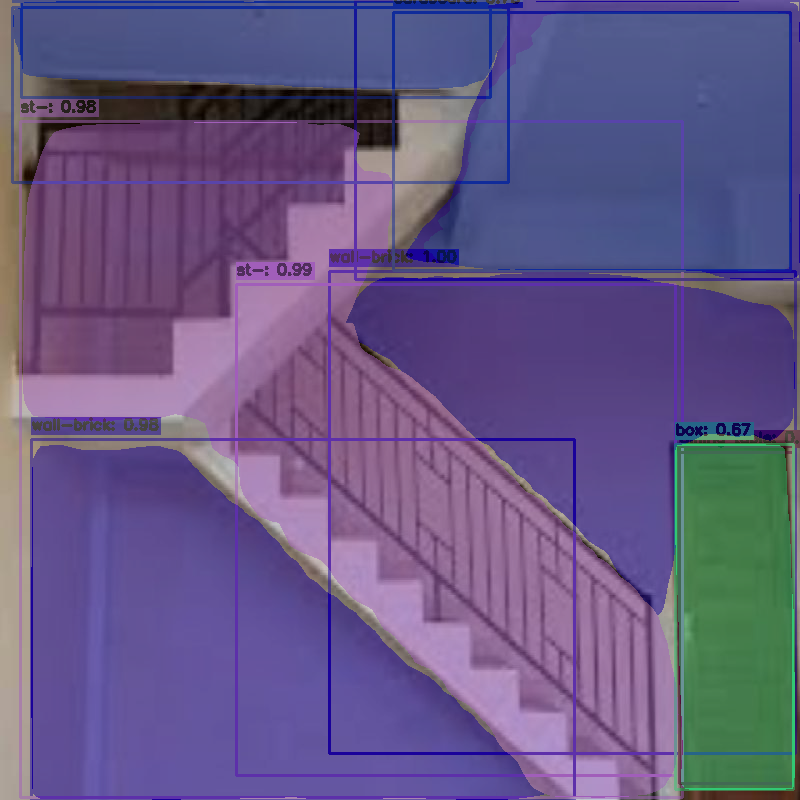


--- Menampilkan Prediksi Acak (2) ---
--- Menampilkan Prediksi Acak untuk Gambar Indeks: 111 ---


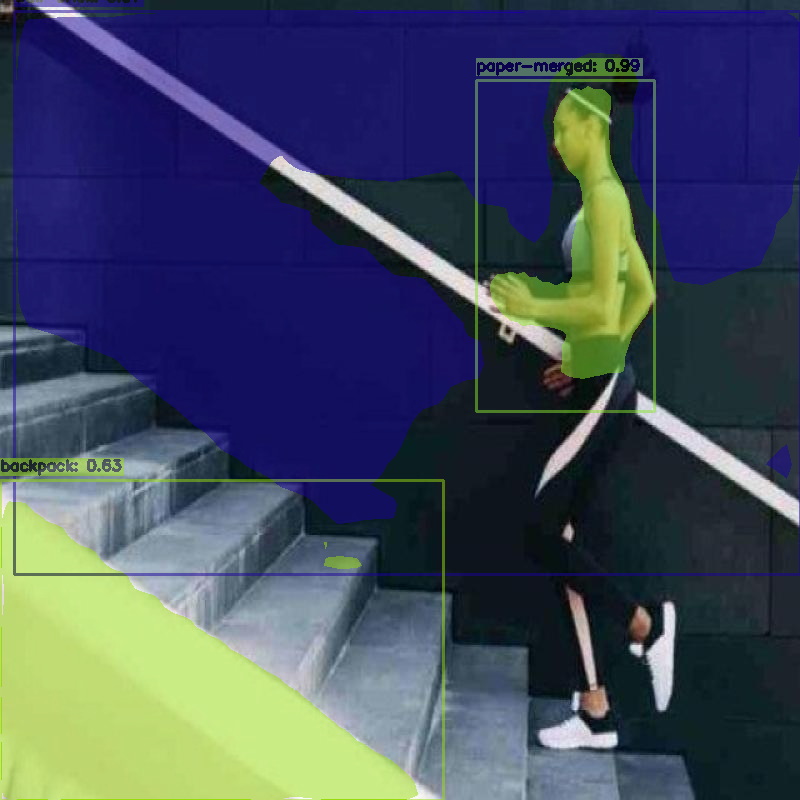


--- Menampilkan Prediksi Acak (3) ---
--- Menampilkan Prediksi Acak untuk Gambar Indeks: 161 ---


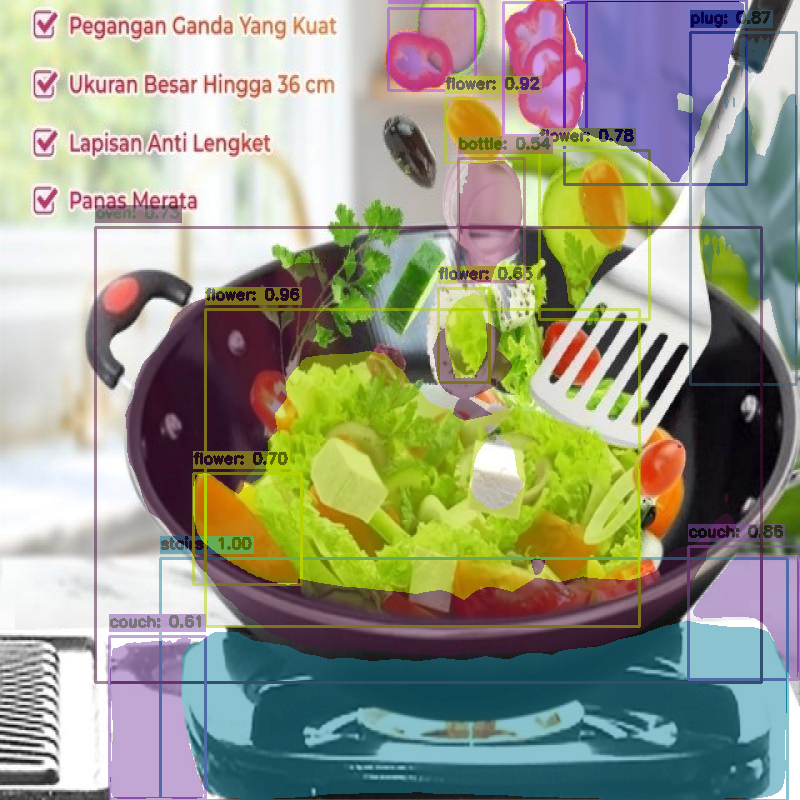

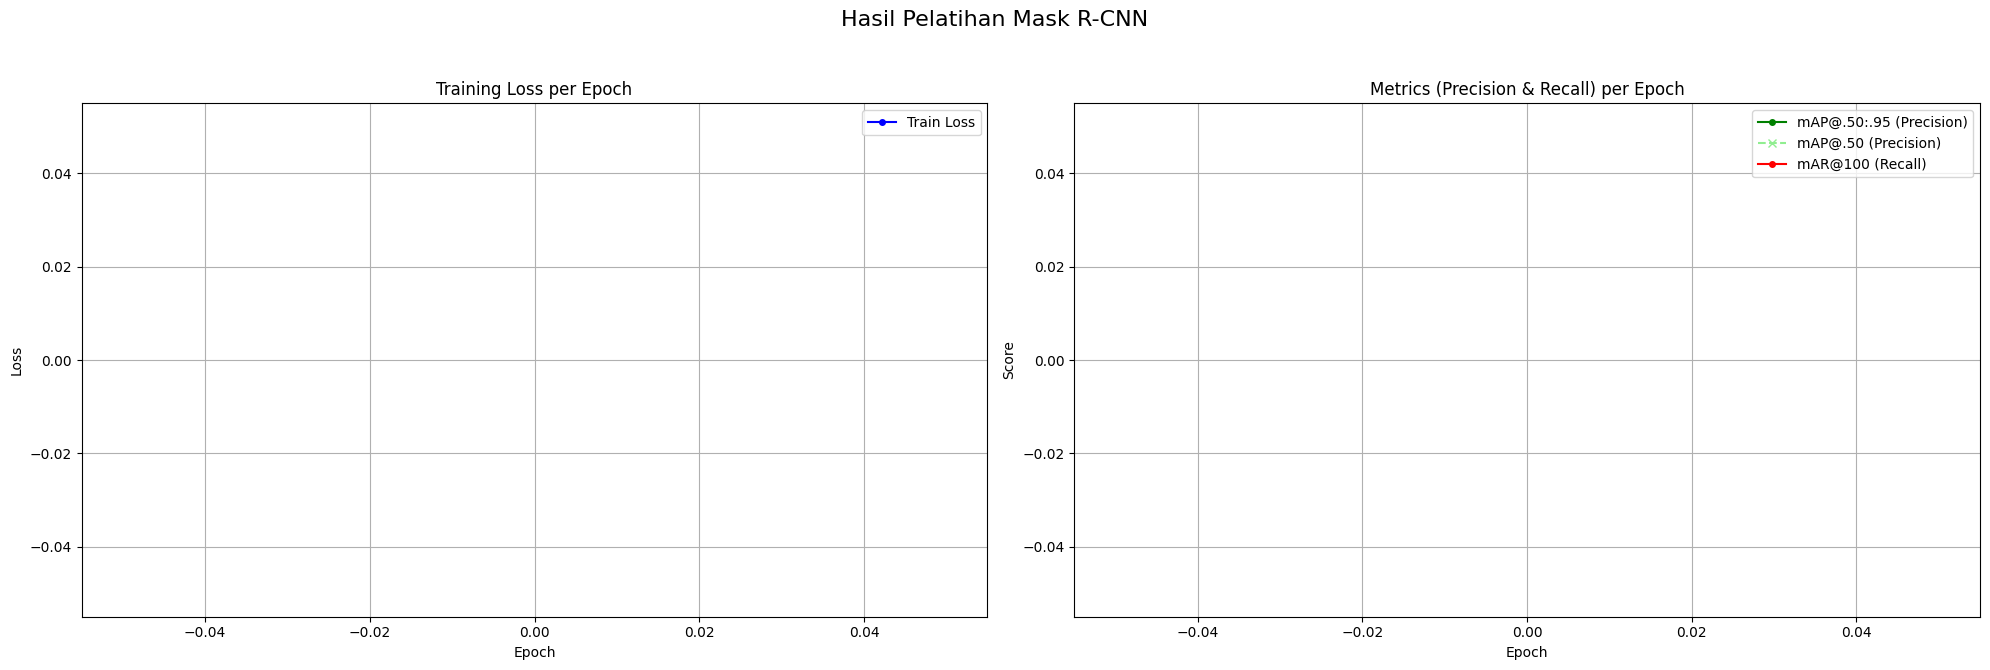

In [35]:
model.eval()

print("\n--- Menampilkan Prediksi Acak (1) ---")
visualize_random_prediction(model, dataset_valid, device, class_names, threshold=0.5)

print("\n--- Menampilkan Prediksi Acak (2) ---")
visualize_random_prediction(model, dataset_valid, device, class_names, threshold=0.5)

print("\n--- Menampilkan Prediksi Acak (3) ---")
visualize_random_prediction(model, dataset_valid, device, class_names, threshold=0.5)

if 'history' in locals():
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Hasil Pelatihan Mask R-CNN', fontsize=16)

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss', color='blue', marker='o', markersize=4)
    ax1.set_title('Training Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot mAP (Precision) & mAR (Recall)
    ax2.plot(history['map_50_95'], label='mAP@.50:.95 (Precision)', color='green', marker='o', markersize=4)
    ax2.plot(history['map_50'], label='mAP@.50 (Precision)', color='lightgreen', linestyle='--', marker='x')
    ax2.plot(history['mar_100'], label='mAR@100 (Recall)', color='red', marker='o', markersize=4)
    ax2.set_title('Metrics (Precision & Recall) per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\n[Info] 'history' tidak ditemukan. Lewati plot Matplotlib.")
    print("Untuk mengaktifkan, modifikasi loop pelatihan Anda untuk menyimpan 'history'.")